# Using submodels in PyBaMM
In this notebook we show how to modify existing models by swapping out submodels, and how to build your own model from scratch using exisitng submodels. To see all of the models and submodels available in PyBaMM, please take a look at the documentation [here](https://pybamm.readthedocs.io/en/latest/source/models/index.html).

## Changing a submodel in an exisiting battery model
PyBaMM is designed to be a flexible modelling package that allows users to easily compare different models and numerical techniques within a common framework. Battery models within PyBaMM are built up using a number of submodels that describe different physics included within the model, such as mass conservation in the electrolyte or charge conservation in the solid. For ease of use, a number of popular battery models are pre-configured in PyBaMM. As an example, we look at the Single Particle Model (for more information see [here](./models/SPM.ipynb)). First we import PyBaMM and any other packages we need

In [1]:
import pybamm
import os
import numpy as np
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

Then we load the SPM

In [2]:
model = pybamm.lithium_ion.SPM()

We can look at the submodels that make up the SPM by accessing `model.submodels`, which is a dictionary of the submodel's name (i.e. the physics it represents) and the submodel that is selected

In [3]:
for name, submodel in model.submodels.items():
    print(name, submodel)

porosity <pybamm.models.submodels.porosity.constant_porosity.Constant object at 0x7fa33e506358>
convection <pybamm.models.submodels.convection.no_convection.NoConvection object at 0x7fa33e506a90>
negative interface <pybamm.models.submodels.interface.lithium_ion.InverseButlerVolmer object at 0x7fa33e506ac8>
positive interface <pybamm.models.submodels.interface.lithium_ion.InverseButlerVolmer object at 0x7fa33e506b00>
negative particle <pybamm.models.submodels.particle.fickian.fickian_single_particle.SingleParticle object at 0x7fa33e506b38>
positive particle <pybamm.models.submodels.particle.fickian.fickian_single_particle.SingleParticle object at 0x7fa33e506b70>
negative electrode <pybamm.models.submodels.electrode.ohm.leading_ohm.LeadingOrder object at 0x7fa33e506ba8>
electrolyte conductivity <pybamm.models.submodels.electrolyte.stefan_maxwell.conductivity.leading_stefan_maxwell_conductivity.LeadingOrder object at 0x7fa33e506be0>
electrolyte diffusion <pybamm.models.submodels.electroly

When you load a model in PyBaMM it builds by default. Building the model sets all of the model variables and sets up any variables which are coupled between different submodels: this is the process which couples the submodels together and allows one submodel to access variables from another. If you would like to swap out a submodel in an exisitng battery model you need to load it without building it by passing the keyword `build=False`

In [4]:
model = pybamm.lithium_ion.SPM(build=False)

This collects all of the submodels which make up the SPM, but doesn't build the model. Now you are free to swap out one submodel for another. For instance, you may want to assume that diffusion within the negative particles is infinitely fast, so that the PDE describing diffusion is replaced with an ODE for the uniform particle concentration. To change a submodel you simply update the dictionary entry

In [5]:
model.submodels["negative particle"] = pybamm.particle.fast.SingleParticle(model.param, "Negative")

Now if we look at the submodels again we see that the model for the negative particle has been changed

In [6]:
for name, submodel in model.submodels.items():
    print(name, submodel)

porosity <pybamm.models.submodels.porosity.constant_porosity.Constant object at 0x7fa33e0681d0>
convection <pybamm.models.submodels.convection.no_convection.NoConvection object at 0x7fa33e068208>
negative interface <pybamm.models.submodels.interface.lithium_ion.InverseButlerVolmer object at 0x7fa33e068240>
positive interface <pybamm.models.submodels.interface.lithium_ion.InverseButlerVolmer object at 0x7fa33e068278>
negative particle <pybamm.models.submodels.particle.fast.fast_single_particle.SingleParticle object at 0x7fa33e110940>
positive particle <pybamm.models.submodels.particle.fickian.fickian_single_particle.SingleParticle object at 0x7fa33e0682e8>
negative electrode <pybamm.models.submodels.electrode.ohm.leading_ohm.LeadingOrder object at 0x7fa33e068320>
electrolyte conductivity <pybamm.models.submodels.electrolyte.stefan_maxwell.conductivity.leading_stefan_maxwell_conductivity.LeadingOrder object at 0x7fa33e068358>
electrolyte diffusion <pybamm.models.submodels.electrolyte.ste

Building the model also sets up the equations, boundary and initial conditions for the model. For example, if we look at `model.rhs` before building we see that it is empty 

In [7]:
model.rhs

{}

If we try to use this empty model, PyBaMM will give an error. So, before proceeding we must build the model

In [8]:
model.build_model()

Now if we look at `model.rhs` we see that it contains an entry relating to the concentration in each particle, as expected for the SPM

In [9]:
model.rhs

{Variable(-0x3cdc128c884d9c10, X-averaged negative particle surface concentration, children=[], domain=['current collector'], auxiliary_domains={}): Division(0x5bb7507a231a7556, /, children=['-3.0 * broadcast(Current function / Typical current [A] * function (sign)) / Negative electrode thickness [m] / Negative electrode thickness [m] + Separator thickness [m] + Positive electrode thickness [m]', 'Negative electrode surface area density [m-1] * Negative particle radius [m]'], domain=['current collector'], auxiliary_domains={}),
 Variable(-0x5815563c2dff222c, X-averaged positive particle concentration, children=[], domain=['positive particle'], auxiliary_domains={'secondary': "['current collector']"}): Multiplication(-0x2939bd9275c629cb, *, children=['-1.0 / Positive particle radius [m] ** 2.0 / Positive electrode diffusivity / 96485.33289 * Maximum concentration in negative electrode [mol.m-3] * Negative electrode thickness [m] + Separator thickness [m] + Positive electrode thickness [

Now the model can be processed and solved in the usual way, and we still have access to model defaults such as the default geometry and default spatial methods

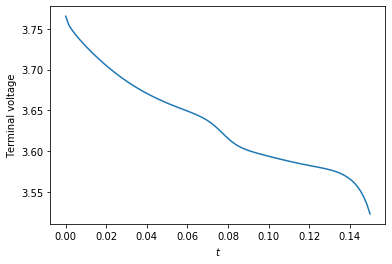

In [10]:
# create geometry
geometry = model.default_geometry

# load parameter values and process model and geometry
param = model.default_parameter_values
param.process_model(model)
param.process_geometry(geometry)

# set mesh
mesh = pybamm.Mesh(geometry, model.default_submesh_types, model.default_var_pts)

# discretise model
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model)

# solve model
t_eval = np.linspace(0, 0.15, 100)
solution = model.default_solver.solve(model, t_eval)

# post-process voltage for plotting
voltage = pybamm.ProcessedVariable(model.variables['Terminal voltage [V]'], solution.t, solution.y, mesh=mesh)

# plot
plt.plot(solution.t, voltage(solution.t))
plt.xlabel(r'$t$')
plt.ylabel('Terminal voltage')
plt.show()

## Building a custom model from submodels
Instead of editing a pre-exisitng model, you may wish to build your own model from scratch by combining exisitng submodels of you choice. In this section, we build a Single Particle Model in which the diffusion is assumed infinitely fast in both particles. 

To begin, we load a base lithium-ion model. This sets up the basic model structure behind the scenes, and also sets the default paramaters to be those corresponding to a lithium-ion battery. Note that the base model does not select any default submodels, so there is no need to pass `build=False`.

In [11]:
model = pybamm.lithium_ion.BaseModel()

Submodels can be added to the `model.submodels` dictionary in the same way that we changed the submodels earlier. 

We want to build a 1D model, so select the `Uniform` current collector model (if the current collectors are behaving uniformly, then a 1D model is appropriate). We also want the model to be isothermal, so slect the thermal model accordingly. 

In [12]:
model.submodels["current collector"] = pybamm.current_collector.Uniform(model.param)
model.submodels["thermal"] = pybamm.thermal.isothermal.Isothermal(model.param)

We assume that the current density varies linearly in the electrodes. This corresponds the the leading-order terms in Ohm's law in the limit in which the SPM is derived in [1]

In [13]:
model.submodels["negative electrode"] = pybamm.electrode.ohm.LeadingOrder(
    model.param, "Negative"
)
model.submodels["positive electrode"] = pybamm.electrode.ohm.LeadingOrder(
    model.param, "Positive"
)

We assume that diffusion is infinitely fast in both the negative and positive particles 

In [14]:
model.submodels["negative particle"] = pybamm.particle.fast.SingleParticle(
    model.param, "Negative"
)
model.submodels["positive particle"] = pybamm.particle.fast.SingleParticle(
    model.param, "Positive"
)

In the Single Particle Model, the overpotential can be obtianed by inverting the Butler-Volmer relation, so we choose the `InverseButlerVolmer` submodel for the interface

In [15]:
model.submodels[
    "negative interface"
] = pybamm.interface.lithium_ion.InverseButlerVolmer(model.param, "Negative")
model.submodels[
    "positive interface"
] = pybamm.interface.lithium_ion.InverseButlerVolmer(model.param, "Positive")


Finally, for the electrolyte we assume that diffusion is infinitely fast so that the concentration is uniform, and also use the leading-order model for charge conservation, which leads to a linear variation in ionic current in the electrodes

In [16]:
electrolyte = pybamm.electrolyte.stefan_maxwell
model.submodels["electrolyte diffusion"] = electrolyte.diffusion.ConstantConcentration(
    model.param
)
model.submodels["electrolyte conductivity"] = electrolyte.conductivity.LeadingOrder(
    model.param
)

Now that we have set all of the submodels we can build the model

In [17]:
model.build_model()

The base lithium-ion model doesn't come with a default geometry, so we choose a 1D macroscopic geometry for the electrodes and separator, and 1D microscopic geometry for the particles (i.e. the geometry of the standard Newman model [2])

In [18]:
geometry = pybamm.Geometry("1D macro", "1D micro")

The base model does come with defaults for the parameters, spatial methods and submeshes, so we can now proceed to solve the model in the usual way 

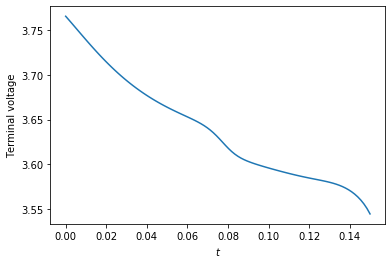

In [19]:
# process model and geometry
param = model.default_parameter_values
param.process_model(model)
param.process_geometry(geometry)

# set mesh
mesh = pybamm.Mesh(geometry, model.default_submesh_types, model.default_var_pts)

# discretise model
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model)

# solve model
t_eval = np.linspace(0, 0.15, 100)
solver = pybamm.ScipySolver()
solution = solver.solve(model, t_eval)

# post-process voltage for plotting
voltage = pybamm.ProcessedVariable(model.variables['Terminal voltage [V]'], solution.t, solution.y, mesh=mesh)

# plot
plt.plot(solution.t, voltage(solution.t))
plt.xlabel(r'$t$')
plt.ylabel('Terminal voltage')
plt.show()

## References
[1] SG Marquis, V Sulzer, R Timms, CP Please and SJ Chapman. “An asymptotion derivation of a single particle model with electrolyte”. In: arXiv preprint arXiv:1905.12553 (2019).

[2] M Doyle, TF Fuller and J Newman. "Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell." Journal of the Electrochemical Society 140.6 (1993): 1526-1533.